## Import needed libraries

In [1]:
import cv2 as cv
import numpy as np

# Pyramid construction

In [ ]:
def build_pyramid(image, levels):
    """
    Builds a Gaussian pyramid from an image.
    
    :param image: Input image
    :type image: numpy.ndarray
    :param levels: Number of levels in the pyramid
    :type levels: int
    :return: List of images in the pyramid
    :rtype: list
    """
    pyramid = [image]
    
    for l in range(1, levels+1):
        prev = pyramid[l-1]
        pyramid.append(cv.pyrDown(prev))

    return pyramid

# Something

In [3]:
def compute_gradients(image):
    """
    Computes the gradients of an image using Sobel operator.

    :param image: Input image
    :type image: numpy.ndarray
    :return: Gradients in x and y directions
    :rtype: tuple
    """

    Ix = cv.Sobel(image, cv.CV_32F, 1, 0, ksize=3)
    Iy = cv.Sobel(image, cv.CV_32F, 0, 1, ksize=3)
    return Ix, Iy

In [4]:
def refine_flow(I1_l, I2_l, Ix, Iy, u, v, w, K):
    """
    Refines the optical flow using the Lucas-Kanade method.

    :param I1_l: Pyramid level of the first image
    :type I1_l: numpy.ndarray
    :param I2_l: Pyramid level of the second image
    :type I2_l: numpy.ndarray
    :param Ix: Gradient in x direction
    :type Ix: numpy.ndarray
    :param Iy: Gradient in y direction
    :type Iy: numpy.ndarray
    :param u: Initial flow in x direction
    :type u: numpy.ndarray
    :param v: Initial flow in y direction
    :type v: numpy.ndarray
    :param w: Window size
    :type w: int
    :param K: Number of iterations
    :type K: int
    :return: Refined flow in x and y directions
    :rtype: tuple
    """

    height, width = I1_l.shape
    for y in range(w // 2, height - w // 2):
        for x in range(w // 2, width - w // 2):
            delta_u = 0.0
            delta_v = 0.0

            for _ in range(K):
                x2 = x + u[y, x] + delta_u
                y2 = y + v[y, x] + delta_v

                if x2 < 0 or x2 >= width or y2 < 0 or y2 >= height:
                    break

                It = I2_l[int(y2), int(x2)] - I1_l[y, x]

                window_x = x - w // 2
                window_y = y - w // 2

                Ix_win = Ix[window_y:window_y + w, window_x:window_x + w].flatten()
                Iy_win = Iy[window_y:window_y + w, window_x:window_x + w].flatten()

                ATA_11 = np.sum(Ix_win * Ix_win)
                ATA_12 = np.sum(Ix_win * Iy_win)
                ATA_21 = ATA_12
                ATA_22 = np.sum(Iy_win * Iy_win)

                ATb_1 = -np.sum(Ix_win * It)
                ATb_2 = -np.sum(Iy_win * It)

                det = ATA_11 * ATA_22 - ATA_12 * ATA_21
                if det > 1e-6:
                    delta_du = (ATA_22 * ATb_1 - ATA_12 * ATb_2) / det
                    delta_dv = (-ATA_21 * ATb_1 + ATA_11 * ATb_2) / det

                    delta_u += delta_du
                    delta_v += delta_dv

            u[y, x] += delta_u
            v[y, x] += delta_v

    return u, v

In [5]:
def PyramidalLK(I1, I2, L, w, K):
    u = np.zeros(I1.shape, dtype=np.float32)
    v = np.zeros(I1.shape, dtype=np.float32)

    pyramid1 = build_pyramid(I1, L)
    pyramid2 = build_pyramid(I2, L)

    for l in range(L, -1, -1):
        I1_l = pyramid1[l]
        I2_l = pyramid2[l]

        if l < L:
            new_size = (I1_l.shape[1], I1_l.shape[0])
            u = 2 * cv.resize(u, new_size, interpolation=cv.INTER_LINEAR)
            v = 2 * cv.resize(v, new_size, interpolation=cv.INTER_LINEAR)

        Ix, Iy = compute_gradients(I1_l)
        u, v = refine_flow(I1_l, I2_l, Ix, Iy, u, v, w, K)

    return u, v

In [ ]:
def visualize_optical_flow(u, v):
    h, w = u.shape
    hsv = np.zeros((h, w, 3), dtype=np.uint8)

    # Convert flow to polar coordinates (magnitude and angle)
    magnitude, angle = cv.cartToPolar(u, v, angleInDegrees=True)

    # Set hue according to the optical flow direction
    hsv[..., 0] = angle / 2  # OpenCV hue range is [0,180]

    # Set value according to the optical flow magnitude (normalized)
    hsv[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)

    # Set saturation to max
    hsv[..., 1] = 255

    # Convert HSV to BGR for display
    flow_bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)

    # Show or save the result
    while True:
        cv.resize(flow_bgr, (50, 50), interpolation=cv.INTER_LINEAR)
        cv.imshow('Optical Flow HSV', flow_bgr)


        if cv.waitKey(1) & 0xFF == ord('q'):
            break

    cv.destroyAllWindows()





# Testing

In [53]:
I1 = cv.imread("./resources/frame1.png", flags=cv.IMREAD_GRAYSCALE)
I2 = cv.imread("./resources/frame2.png", flags=cv.IMREAD_GRAYSCALE)

In [54]:
pyramid = build_pyramid(I1, 3)
for img in pyramid:
    print(img.shape)

(768, 1368)
(384, 684)
(192, 342)
(96, 171)


C:\Users\diaal\AppData\Local\Temp\ipykernel_14236\1851491327.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


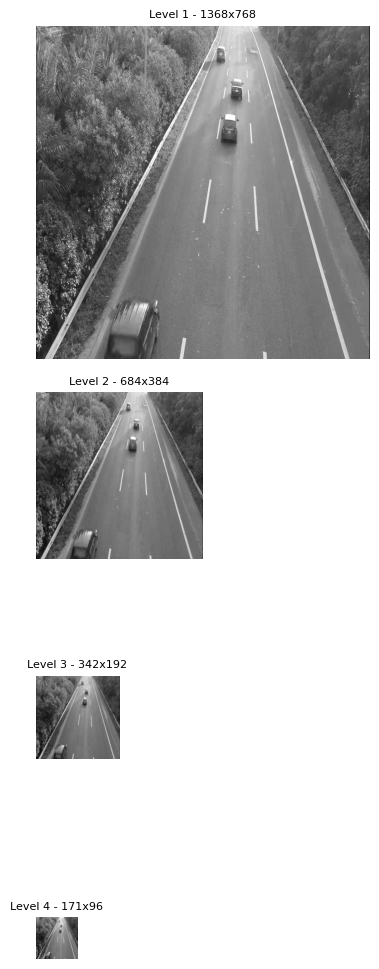

In [47]:
import matplotlib.pyplot as plt

# Base image for reference
base_img = pyramid[0]

# Create a figure
plt.figure(figsize=(10, 10))

# Display each image in the pyramid
for idx, img in enumerate(pyramid, start=1):
    # Calculate normalized dimensions for display
    scale_factor = 3  # Adjust this to control the size of displayed images
    left = 0.1  # Fixed horizontal position
    bottom = 0.1 + (len(pyramid) - idx) * 0.2  # Dynamic vertical position based on level
    width = img.shape[1] / base_img.shape[1] / scale_factor
    height = img.shape[0] / base_img.shape[0] / scale_factor

    # Create an axis for the image
    ax = plt.axes([left, bottom, width, height])
    ax.imshow(img, cmap='gray', aspect='auto')
    ax.set_title(f'Level {idx} - {img.shape[1]}x{img.shape[0]}', fontsize=8)
    ax.axis('off')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [48]:
u, v = PyramidalLK(I1, I2, 3, 3, 3)

C:\Users\diaal\AppData\Local\Temp\ipykernel_14236\142675398.py:38: RuntimeWarning: overflow encountered in scalar subtract
  It = I2_l[int(y2), int(x2)] - I1_l[y, x]


In [76]:
visualize_optical_flow(u, v)